In [1]:
%matplotlib inline
from keras.layers.core import Dropout, Flatten, Dense
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import RMSprop, Adam
from keras.losses import binary_crossentropy 
from keras_preprocessing.image import ImageDataGenerator #for image preprocessing
import seaborn as sns #for plotting
import numpy as np
import matplotlib.pyplot as plt
import os

Using TensorFlow backend.


In [2]:
train_data = r'C:\Users\fabio\Documents\DataSets\cell_images\train_base\train_data'
validation_data = r'C:\Users\fabio\Documents\DataSets\cell_images\train_base\validation_data'
test_data = r'C:\Users\fabio\Documents\DataSets\cell_images\test_data'

In [3]:
train_batch_size = 100
val_batch_size = 55
train_data_size = 12000
val_data_size = 10780
train_steps = train_data_size / train_batch_size
val_steps = val_data_size / val_batch_size

In [4]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   horizontal_flip=True,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    directory=train_data,
    target_size=(60, 60),
    class_mode='binary',
    batch_size=train_batch_size
)

Found 12000 images belonging to 2 classes.


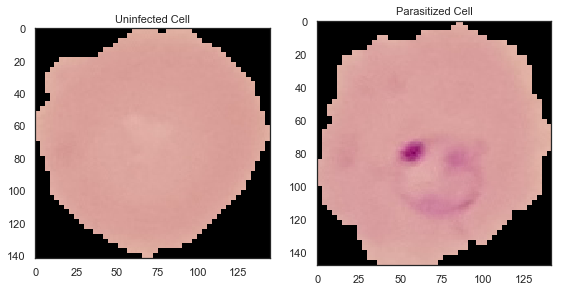

In [5]:
import cv2
img_path_parasitized = r'C:\Users\fabio\Documents\DataSets\cell_images\train_base\train_data\train_parasitized'
img_path_uninfected = r'C:\Users\fabio\Documents\DataSets\cell_images\train_base\train_data\train_uninfected'
imgs_par = [os.path.join(img_path_parasitized, fname) for fname in os.listdir(img_path_parasitized)]
imgs_unin = [os.path.join(img_path_uninfected, fname) for fname in os.listdir(img_path_uninfected)]
img_path_par = imgs_par[0]
img_path_unin = imgs_unin[2]
img_par = cv2.imread(img_path_par)
img_unin = cv2.imread(img_path_unin)

sns.set(rc={'figure.figsize' : (8, 6)})
sns.set_style('white')
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img_unin, cv2.COLOR_BGR2RGB))
plt.title("Uninfected Cell", fontsize=11)
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(img_par, cv2.COLOR_BGR2RGB))
plt.title("Parasitized Cell", fontsize=11)
plt.tight_layout()
plt.show()

In [6]:
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    directory=validation_data,
    target_size=(60, 60),
    batch_size=val_batch_size,
    class_mode='binary'
)

Found 10780 images belonging to 2 classes.


In [7]:
callback_list = [EarlyStopping(patience=5, monitor='acc')]

In [13]:
model = Sequential([Conv2D(12, (5, 5), activation='relu', input_shape=(60, 60, 3)),
                    Conv2D(32, (3, 3), activation='relu'),
                    Conv2D(64, (3, 3), activation='relu'),
                    MaxPooling2D(2, 2),
                    Conv2D(128, (3, 3), activation='relu'),
                    Conv2D(142, (1, 1), activation='relu'),
                    Conv2D(152, (1, 1), activation='relu'),
                    MaxPooling2D(2, 2),
                    Conv2D(164, (1, 1), activation='relu'),
                    Conv2D(182, (1, 1), activation='relu'),
                    Conv2D(200, (1, 1), activation='relu'),
                    MaxPooling2D(2, 2),
                    Flatten(),
                    Dropout(0.5),
                    Dense(150, activation='relu'),
                    Dense(1, activation='sigmoid')])

In [14]:
model.compile(loss=binary_crossentropy,
              optimizer=Adam(),
              metrics=['acc'])

In [15]:
hist = model.fit_generator(train_generator,
                           steps_per_epoch=train_steps,
                           epochs=15,
                           validation_steps=val_steps,
                           validation_data=validation_generator,
                           callbacks=callback_list,
                           )

Epoch 1/15
120/120 [==============================] - 542s 5s/step - loss: 0.6374 - acc: 0.6325 - val_loss: 0.5658 - val_acc: 0.6981
Epoch 2/15
120/120 [==============================] - 104s 867ms/step - loss: 0.3050 - acc: 0.8814 - val_loss: 0.2360 - val_acc: 0.9065
Epoch 3/15
120/120 [==============================] - 83s 693ms/step - loss: 0.2714 - acc: 0.8900 - val_loss: 0.2114 - val_acc: 0.9346
Epoch 4/15
120/120 [==============================] - 83s 693ms/step - loss: 0.2584 - acc: 0.9060 - val_loss: 0.1962 - val_acc: 0.9384
Epoch 5/15
120/120 [==============================] - 83s 691ms/step - loss: 0.2339 - acc: 0.9126 - val_loss: 0.1912 - val_acc: 0.9487
Epoch 6/15
120/120 [==============================] - 83s 693ms/step - loss: 0.2205 - acc: 0.9174 - val_loss: 0.1874 - val_acc: 0.9452
Epoch 7/15
120/120 [==============================] - 85s 705ms/step - loss: 0.2134 - acc: 0.9210 - val_loss: 0.1899 - val_acc: 0.9432
Epoch 8/15
120/120 [==============================] - 84

In [17]:
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']

train_acc = hist.history['acc']
val_acc = hist.history['val_acc']

epochs = range(1, 1 + len(train_loss))

In [ ]:
#Evaluates the model's accuracy on the test set.

In [51]:
def loss_val_curves(epochs=0.0, train_loss=0.0, val_loss=0.0, train_acc=0.0, val_acc=0.0):
    plt.subplot(1, 2, 1)
    sns.set_style('darkgrid')
    sns.lineplot(x=epochs, y=train_loss, color='blue', label='Train Loss')
    sns.lineplot(x=epochs, y=val_loss, color='red', label='Validation Loss')
    plt.title('Train and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.subplot(1, 2, 2)
    sns.lineplot(x=epochs, y=train_acc, color='blue', label='Train Acc')
    sns.lineplot(x=epochs, y=val_acc, color='red', label='Validation Acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Train and Validation Accuracy')
    sns.set(rc={'figure.figsize' : (5, 5)})
    plt.show()

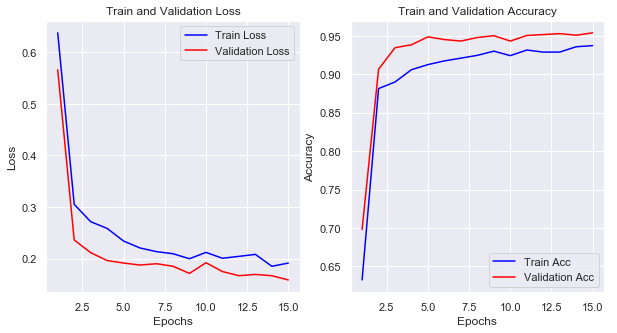

In [52]:
loss_val_curves(epochs, train_loss, val_loss, train_acc, val_acc)

In [40]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(directory=test_data,
                                                  target_size=(60, 60),
                                                  batch_size=1,
                                                  class_mode='binary',
                                                  shuffle=False,
                                                  color_mode='rgb'
                                                  )

Found 4778 images belonging to 2 classes.


In [41]:
test_samples = 4778 
probabilities = model.predict_generator(test_generator, steps=test_samples)

In [ ]:
class_map = {1 : 'Parasitized', 0. : 'Uninfected'}

In [53]:
ground_truth = test_generator.classes

In [54]:
predictions = probabilities

In [55]:
predictions[probabilities>0.5]=1
predictions[probabilities!=1]=0

In [56]:
predictions = predictions.reshape(ground_truth.shape)

In [57]:
predictions

array([0., 0., 0., ..., 1., 1., 1.], dtype=float32)

In [ ]:
def convert_to_class(probabilities):
    classes = []
    for i in probabilities:
        if i > 0.5:
            classes.append(1)
        else:
            classes.append(0)
    return classes

In [58]:
from sklearn.metrics import accuracy_score
#predictions = np.array(convert_to_class(probabilities))
print('Test Accuracy: %.2f' % accuracy_score(ground_truth, predictions))

Test Accuracy: 0.96


In [59]:
model.save(r'C:\Users\fabio\Documents\models\malaria_detection_model.h5')

In [60]:
from keras.models import load_model
loaded_model = load_model(r'C:\Users\fabio\Documents\models\malaria_detection_model.h5')

In [61]:
probabilities = loaded_model.predict_generator(test_generator, steps=test_samples) #load the saved model.

In [ ]:
predictions = np.array(convert_to_class(probabilities))

In [62]:
print('Test Accuracy: %.2f' % accuracy_score(ground_truth, predictions))

Test Accuracy: 0.96


In [63]:
#Predicting the class of a cell.
from keras.preprocessing import image
#Converting to a Numpy array
img_path_par = imgs_par[0]
img = image.load_img(img_path_par, target_size=(60, 60, 3))
x = image.img_to_array(img)
x = x.reshape((1,) +  x.shape)
loaded_model.predict(x)

array([[0.]], dtype=float32)

In [ ]:
img_path_unin = imgs_unin[0]
img = image.load_img(img_path_unin, target_size=(60, 60, 3))
x = image.img_to_array(img)
x = x.reshape((1,) + x.shape)
loaded_model.predict(x)

In [ ]:
#Fits the model using a pretrained convnet.

In [ ]:
from keras.applications.vgg19 import VGG19
VGG19(weights='imagenet',
     include_top=False,
     input_shape=(60, 60, 3)).summary()

In [ ]:
def pretrained_model(num_units, trainable=False, output_units=1, act='sigmoid'):
    conv_base = VGG19(weights='imagenet',
                      include_top=False,
                      input_shape=(60, 60, 3))
    model = Sequential([conv_base,
                        Flatten(),
                        Dense(num_units, activation='relu'),
                        Dense(output_units, activation=act)])
    model.trainable = trainable
    return model

In [ ]:
pretrained_mod = pretrained_model(num_units=150, trainable=True)

In [ ]:
pretrained_mod.compile(loss=binary_crossentropy,
                       optimizer=Adam(lr=0.001),
                       metrics=['acc'])

In [ ]:
pretrained_hist = pretrained_mod.fit_generator(train_generator,
                                    steps_per_epoch=train_steps,
                                    epochs=15,
                                    validation_steps=val_steps,
                                    validation_data=validation_generator,
                                    callbacks=callback_list,
                                   )

In [ ]:
loss = pretrained_hist.history['loss']
val_loss = pretrained_hist.history['val_loss']

train_acc = pretrained_hist.history['acc']
val_acc = pretrained_hist.history['val_acc']

epochs = range(1, 1 + len(loss))

In [ ]:
loss_val_curves(epochs, train_loss=loss, train_acc=train_acc, val_loss=val_loss, val_acc=val_acc)